#### Library

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML


last_method = None
method_params = None
def step(i,t,x,dydt,method,dt):
    global last_method, method_params
    if method=="Euler":
        k1 = dydt(t[i],x[i])*dt
        last_method = method
        return x[i] + k1
    elif method=="RK2":
        k1 = dydt(t[i],x[i])*dt
        k2 = dydt(t[i]+dt,x[i]+k1)*dt
        last_method = method
        return x[i] + (k1+k2)/2
    elif method.startswith("RK2("):
        if method == last_method:
            a1,a2,p,q = method_params
        else:
            params = method[4:-1].strip().split(",")
            ARGS = []
            KWARGS = {"a1":None,"a2":None,"p":None,"q":None}
            for x in params:
                if "=" in x :
                    P,V = x.split("=")
                    KWARGS[P.strip().lower()] = float(V)
                else:
                    ARGS.append(float(x))
            ARGS = ARGS[::-1]
            for x in KWARGS:
                if KWARGS[x] is None:
                    KWARGS[x] = ARGS.pop()
            if KWARGS["a2"] is None: a2 = 1 - a1
            else: a2 = KWARGS["a2"]
            if KWARGS["a1"] is None: a1 = 1 - a2
            else: a1 = KWARGS["a1"]
            if KWARGS["p"] is None: p = 1/(2*a2)
            else: p = KWARGS["p"]
            if KWARGS["q"] is None: q = 1/(2*a2)
            else: q = KWARGS["q"]
            last_method = method
            method_params = (a1,a2,p,q)

        k1 = dydt(t[i],x[i])*dt
        k2 = dydt(t[i]+(p*dt), x[i]+(k1*q*dt))*dt
        return x[i] + (a1*k1 + a2*k2)

    elif method == "EC":
        k1_theta, k1_omega = dydt(t[i], x[i])*dt
        omega_new = x[i][1] + k1_omega
        theta_new = x[i][0] + dt*omega_new
        return (theta_new,omega_new)

    elif method == "LF": # Leap Frog
        theta, omega = x[i]
        theta_intermediate = theta + dt*omega/2
        k1_theta,k1_omega = dydt(t[i],np.array(theta_intermediate,omega))*dt
        omega_new = omega + k1_omega
        theta_new = theta_intermediate + omega_new*dt/2
        return (theta_new,omega_new)


def Numerical_Solver(
    x_0, # initial value. Can be a single value or numpy array
    dydt, # a function mapping x,t to the derivative
    dt=None,  # Interval \Delat t
    t_ini=0,t_max=None, # real values  
    tau = None,
    precision_level = 100,
    methods=["Euler"],
    x_analytical=None, # analytical solution (function). If avaliable, compute errors too
    visualise=False, # if True, does some plotting
    variable_name=None,
    compute_error=True,
    compute_one_step_error=True,
) -> (tuple[np.ndarray,dict]|tuple[np.ndarray,dict,HTML]):
    if tau is not None:
        if dt is None: dt = tau/precision_level
        if t_max is None: t_max = 10*tau
    t = np.arange(t_ini, t_max, dt)
    N = t.shape[0] -1 # excluding the start value
    if isinstance(x_0,np.ndarray):
        d = x_0.shape[0] # dimension
    elif isinstance(x_0,list) or isinstance(x_0,tuple):
        d = len(x_0)
        x_0 = np.array(x_0)
    else:d =1
    X = {}
    if x_analytical is not None:
        try: x_analytical = x_analytical(t)
        except:x_analytical = np.array([x_analytical(t_i) for t_i in t])
        X["analytical"] = x_analytical
    for method in methods:
        if d > 1:x = np.zeros((N+1,d))
        else:x = np.zeros(N+1)
        x[0] = x_0
        for i in range(0,N):x[i+1] = step(i,t,x,dydt,method,dt)
        X[method] = x
        if x_analytical is not None:
            if compute_error:
                err = x_analytical -x
                X[method + " error"] = err
            if compute_one_step_error:
                x_one_step = x_analytical.copy() 
                for i in range(0,N):
                    x_one_step[i+1] = step(i,t,x_analytical,dydt,method,dt)
                err_one_step = x_analytical - x_one_step
                X[method + " one step error"] = err_one_step
    if visualise and d == 1:
        plt.figure()
        for method in methods:
            plt.plot(t, X[method], label=method)
        if x_analytical is not None:
            plt.plot(t, x_analytical, label="analytical")
        plt.xlabel("$t$")
        if variable_name is not None:plt.ylabel(variable_name)
        plt.title("Numerical Solution (" + ",".join(methods) + ")")
        plt.legend()
        if compute_error and (x_analytical is not None):
            plt.figure()
            for method in methods:
                lbl = method + " error"
                plt.plot(t, X[lbl],label=lbl)
            plt.xlabel("$t$")
            plt.ylabel("error")
            plt.legend()
        if compute_one_step_error and (x_analytical is not None):
            plt.figure()
            for method in methods:
                lbl = method + " one step error"
                plt.plot(t, X[lbl],label=lbl)
            plt.xlabel("$t$")
            plt.ylabel("error")
            plt.legend()
        plt.show()
    elif visualise=="PS" and d == 2:
        fig = plt.figure()
        ax = plt.subplot()
        all_x_min = min([X[m][:,0].min() for m in methods])
        all_y_min = min([X[m][:,1].min() for m in methods])
        all_x_max = max([X[m][:,0].max() for m in methods])
        all_y_max = max([X[m][:,1].max() for m in methods])
        Dx = all_x_max - all_x_min
        Dy = all_y_max - all_y_min
        ax.set_xlim(all_x_min - Dx/10, all_x_max + Dx/10)
        ax.set_ylim(all_y_min - Dy/10, all_y_max + Dy/10)

        LINES = {method : ax.plot([],[],'-',label=method)[0] for method in methods}
        POINTS = {method : ax.plot([],[],'bo')[0] for method in methods}
        ax.set_xlabel(variable_name[0])
        ax.set_ylabel(variable_name[1])
        ax.legend()
        def update(i):
            for method in methods:
                x,y = X[method][:i+1,0],X[method][:i+1,1]
                LINES[method].set_data(x,y)
                POINTS[method].set_data([x[i]],[y[i]])
            return [x for x in LINES.values()] + [x for x in POINTS.values()]
        ani = FuncAnimation(fig, update, frames=len(t), interval=50, blit=False)
        plt.close(fig)
        ani = HTML(ani.to_html5_video())
        return t,X,ani
    elif visualise and d >= 2:
        fig = plt.figure()
        AX:list[plt.Axes] = fig.subplots(d,1,sharex=True)
        for i in range(d) : 
            for method in methods:
                AX[i].plot(t, X[method][:,i], label=method)
            if x_analytical is not None:
                AX[i].plot(t, x_analytical[:,i], label="analytical")
            if variable_name is not None:AX[i].set_ylabel(variable_name[i])
            AX[i].legend()
        AX[-1].set_xlabel("$t$")
        fig.suptitle("Numerical Solution (" + ",".join(methods) + ")")
        if compute_error and (x_analytical is not None):
            fig = plt.figure()
            AX:list[plt.Axes] = fig.subplots(d,1,sharex=True)
            for i in range(d):
                for method in methods:
                    lbl = method + " error"
                    AX[i].plot(t, X[lbl][:,i],label=lbl)
                if variable_name is not None: vn = variable_name[i]
                else: vn = f"var{i}"
                AX[i].set_ylabel("error in " + vn)
                AX[i].legend()
            AX[-1].set_xlabel("$t$")
        if compute_one_step_error and (x_analytical is not None):
            fig = plt.figure()
            AX:list[plt.Axes] = fig.subplots(d,1,sharex=True)
            for i in range(d):
                for method in methods:
                    lbl = method + " one step error"
                    AX[i].plot(t, X[lbl][:,i],label=lbl)
                if variable_name is not None: vn = variable_name[i]
                else: vn = f"var{i}"
                AX[i].set_ylabel("error in " + vn)
                AX[i].legend()
            AX[-1].set_xlabel("$t$")
        plt.show()
    return t,X


def RadioactiveDecay(N_0=1, tau=1, t_max=5, **kwargs):
    def dydt(t,N):return - N / tau
    def N(t):return N_0 * np.exp(-t/tau)
    return Numerical_Solver(
        N_0,dydt,tau=tau,
        x_analytical=N,
        variable_name="$N(t)$",
        **kwargs)

def Aharmonic(y_0=[np.pi/4,0], g=10, l=10, **kwargs):
    def dydt(t,y):
        theta,omega = y[0],y[1]
        return np.array([omega, -(g/l)* np.sin(theta)])
    tau = 2 * np.pi * (l/g)**0.5
    return Numerical_Solver(
        y_0,dydt,tau=tau,
        variable_name=[r"$\theta(t)$",r"$\omega(t)$"],
        **kwargs)

def CoupledRadioactiveDecay(tau_A=1, tau_B=2, N_A_0=1, N_B_0=0,**kwargs):
    def dydt(t,N):
        N_A,N_B = N[0],N[1]
        return np.array([
            -N_A/tau_A,
            N_A/tau_A - N_B/tau_B
            ])
    def N(t):
        assert (not isinstance(t,np.ndarray)) or (t.shape == (1,))
        return np.array([
            np.exp(-t/tau_A),
            (np.exp(-t/tau_A) -np.exp(-t/tau_B))/((tau_A/tau_B)-1)
        ])
    return Numerical_Solver(
        np.array([N_A_0,N_B_0]),dydt,tau=min(tau_A,tau_B),
        x_analytical=N, # analytical solution 
        variable_name=["$N_A(t)$","$N_B(t)$"],
        **kwargs)

## Problem 2

### Non-linear pendulum ###

We need to solve for 

$$ \ddot \theta = -\frac{g}{l} \sin \theta
$$

which can vectorised to a set of two coupled first-order ODEs:

$$\frac{d}{dt} 
    \begin{bmatrix} \theta \\ \dot \theta \end{bmatrix} = 
    \begin{bmatrix} \dot \theta  \\ -(g/l) \sin \theta \end{bmatrix}
$$
given the following **initial condition** at $t=0$,
$$
\begin{bmatrix} \theta \\ \dot \theta \end{bmatrix} = \begin{bmatrix} 0.1 \\ 0.0 \end{bmatrix}.
$$

Explore what happens to the time-period for large amplitudes.

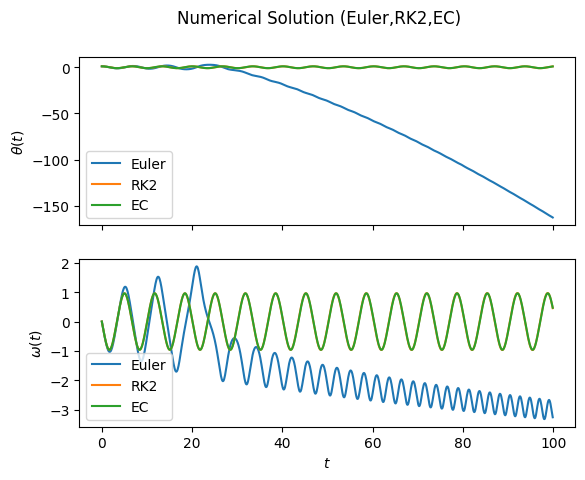

In [9]:
t,res = Aharmonic(y_0=[1,0],visualise=True,methods=["Euler","RK2","EC"],dt=0.1,t_max=100)

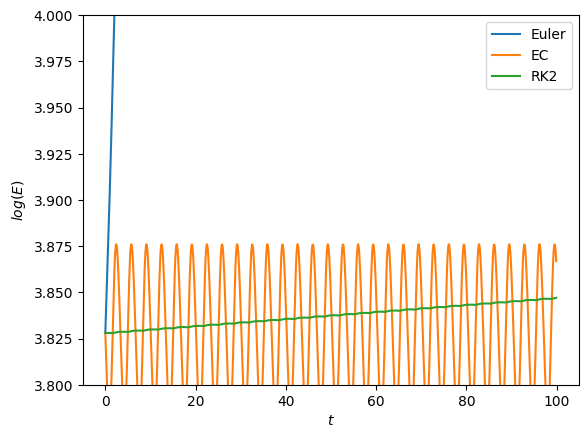

In [11]:
plt.figure()
g = 10
m = 1
l = 10
for method in ["Euler","EC","RK2"]:
    theta = res[method][:,0]
    omega = res[method][:,1]
    E = m*g*l*(1-np.cos(theta)) + (m*(l*omega)**2)/2
    plt.plot(t,np.log(E),label=method)
plt.ylabel("$log(E)$")
plt.xlabel("$t$")
plt.ylim([3.8,4])
plt.legend()
plt.show()

In [14]:
t,res,ani = Aharmonic(y_0=[1,0],visualise="PS",methods=["Euler","RK2","EC"],dt=0.1,t_max=7)
ani